In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install mne
!apt-get install octave
!pip install oct2py
%load_ext oct2py.ipython
!git clone https://github.com/sccn/eeglab.git
!git clone --recurse-submodules https://github.com/sccn/eeglab.git

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
octave is already the newest version (6.4.0-2).
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.
fatal: destination path 'eeglab' already exists and is not an empty directory.
fatal: destination path 'eeglab' already exists and is not an empty directory.


In [ ]:
!pip install -q keras-tcn
!pip install keras
!pip install scikit-learn

In [ ]:
import numpy as np
import pandas as pd
import scipy
from oct2py import octave
import mne
import h5py
from tqdm import tqdm
import os

In [ ]:
octave.addpath('/content/eeglab/functions/adminfunc');
octave.addpath('/content/eeglab/functions/popfunc');
octave.addpath('/content/eeglab/functions/adminfunc');
octave.addpath('/content/eeglab/functions/sigprocfunc');
octave.addpath('/content/eeglab/functions/miscfunc');
octave.addpath('/content/eeglab/functions/statistics');
octave.addpath('/content/eeglab/functions/studyfunc');
octave.addpath('/content/eeglab/functions/supportfiles');
octave.addpath('/content/eeglab/functions/timefreqfunc');

# **Data preparation**

In [ ]:
def events_seperation(matData, events):

		""""
		event -> 0 - type
						 1 - latency
						 2 - urevent
		"""
		len = matData['EEG']['event'][0][0][0].shape[0]

		#events = matData['event']['type'][0]
		#events = matData['EEG']['event'][0][0]
		k = []
		for x in range(len):
			k.append(matData['EEG']['event'][0][0][0][x][0][0])
		events = np.array(k)

		#latency = matData['event']['latency'][0].astype(int)
		#latency = matData['EEG']['event'][1][0].astype(int)

		k = []
		for x in range(len):
			k.append(matData['EEG']['event'][0][0][0][x][1][0][0])
		latency = np.array(k)

		data = matData['EEG']['data'][0][0]


		seperated_data = np.zeros((data.shape[0], 1))
		maxI = events.shape[0]

		for i in range(maxI):
				if (events[i] in events) or (events[i] in np.array(events).astype(int)):
						tmin = latency[i]-1
						if i == maxI-1:
								tmax = data.shape[1]
						else:
								tmax = latency[i+1]-1
						seperated_data = np.append(seperated_data, data[:, tmin:tmax], axis=1)
		seperated_data = np.delete(seperated_data, 0, 1)
		return seperated_data

In [ ]:
def prepare_sources(item, matPathBase, events):
    matName = f'{item}_Depression_REST'
    matItem = matPathBase + matName + '.mat'
    matData = scipy.io.loadmat(matItem)
    seperated_data = events_seperation(matData, events)

    matData['EEG']['times'][0][0] = np.empty(0)
    matData['EEG']['urevent'][0][0] = np.empty(0)
    matData['EEG']['event'][0][0] = np.empty(0)

    setItem = f'{item}.set'
    matData['EEG']['data'][0][0] = seperated_data
    matData['EEG']['pnts'] = float(seperated_data.shape[1])
    temp = octave.eeg_checkset(matData)
    scipy.io.savemat(setItem,temp)
    #octave.pop_saveset(temp, filename=str(item)+'.set', check='on',
    #                 filepath=setPathBase, savemode='onefile');


In [ ]:
def process_signal(raw):
		## Set reference
		raw.set_eeg_reference(ref_channels=['M1', 'M2'])

		## Drop Bad Channels
		raw.drop_channels([x for x in ['CB1', 'CB2', 'EKG', 'HEOG', 'VEOG'] if x in raw.ch_names])

		## Remove Baseline
		raw._data = mne.baseline.rescale(raw.get_data(), raw.times, (None, None))

		## Apply notch filter
		raw.notch_filter(50)

		## Apply Frequency Band Filter
		raw.filter(0.2, 45, method='iir', verbose='WARNING')

		## Apply Butter Filter
		lowcut = 1.0
		highcut = 50.0
		order = 5
		nyq = 0.5 * raw.info['sfreq']
		low = lowcut / nyq
		high = highcut / nyq
		b, a = scipy.signal.butter(order, [low, high], btype='band')
		raw._data = scipy.signal.lfilter(b, a, raw.get_data())

		## Apply ICA Decomposition
		ica = mne.preprocessing.ICA(max_iter=100, random_state=1)
		ica.fit(raw)
		ica.apply(raw)
		return raw



In [ ]:
def windowing(x, y, win_size, bias):
		windowed_x = []
		window_labels = []
		for i in range(0, x.shape[0], bias):
				temp = x[i:i+win_size, :]
				if temp.shape[0]==win_size:
						windowed_x.append(temp)
						window_labels.append(y)
		return windowed_x, window_labels

In [ ]:
def pad_N_epochs(x,limit):
		out = []
		for y in x:
				while len(y) < limit:
						y = np.concatenate([y,y[-(limit-len(y)):]])
				out.append(y[:limit])
		return np.array(out)

In [ ]:
def crop_N_epochs(x,limit):
		return np.array([y[:limit] for y in pad_N_epochs(x,limit)])

In [ ]:
def preprocess_data(itemNums, labelPath, olp, window_time):
		fs = 250
		win_size = window_time*fs
		bias = int((1.0-olp)*win_size)
		seq_len = 60000
		# load labels file
		labels_data = pd.ExcelFile(labelPath)
		labels_data = labels_data.parse('Depression Rest')

		idx = np.array(range(0,seq_len,2))
		data = []
		labels = []
		for item in tqdm(itemNums):
				setItem = f'{item}.set'
				raw = mne.io.read_raw_eeglab(setItem)
				#delta - .5 - 4
				#theta
				#band = [4,8]
				#alpha
				#band = [8,13]
				#beta
				#band = [13,30]
				raw = process_signal(raw)

				item_data = crop_N_epochs(raw._data, seq_len)
				item_data = item_data[:, idx]
				item_data = item_data.reshape(item_data.shape[0], item_data.shape[1])

				item_data = item_data.transpose([1, 0])
				item_label = labels_data[labels_data['id']==item].BDI.values[0]
				windowed_item_data, window_labels = windowing(item_data, item_label, win_size, bias)
				data.append(windowed_item_data)
				labels.append(window_labels)

		data = np.concatenate(data)
		labels = np.concatenate(labels).astype('int16').reshape(-1, 1)
		return data, labels

#MAIN

In [ ]:
"""
itemNums = [*range(507, 512), *range(513, 544), *range(545, 571), *range(573, 629)]
#valid_events
events = ['1', '2', '3', '4', '5', '6', '11', '12', '13', '14', '15', '16']

matPathBase = '/content/drive/MyDrive/Depression Rest/Matlab Files/'
setPathBase = '/content/drive/MyDrive/Depression Rest/set_files/'
labelPath = '/content/drive/MyDrive/Depression Rest/labels.xlsx'

CREATE_SET_FILES = False
EVENT_TYPE = 'open_eyes'
OVERLAP_RATE = 0.9
WINDOW_TIME = 5
"""

"\nitemNums = [*range(507, 512), *range(513, 544), *range(545, 571), *range(573, 629)]\n#valid_events\nevents = ['1', '2', '3', '4', '5', '6', '11', '12', '13', '14', '15', '16']\n\nmatPathBase = '/content/drive/MyDrive/Depression Rest/Matlab Files/'\nsetPathBase = '/content/drive/MyDrive/Depression Rest/set_files/'\nlabelPath = '/content/drive/MyDrive/Depression Rest/labels.xlsx'\n\nCREATE_SET_FILES = False\nEVENT_TYPE = 'open_eyes'\nOVERLAP_RATE = 0.9\nWINDOW_TIME = 5\n"

In [ ]:
"""
if CREATE_SET_FILES:
		if EVENT_TYPE=='open_eyes':
				events = ['2', '4', '6', '12', '14', '16']
		elif EVENT_TYPE=='close_eyes':
				events = ['1', '3', '5', '11', '13', '15']
else:
    #raise('undefined event type!')
    print('Processing Source (.mat) files, get specified events and converting them to .set files')
    for item in tqdm(itemNums):
        prepare_sources(item, matPathBase, events)
"""

"\nif CREATE_SET_FILES:\n\t\tif EVENT_TYPE=='open_eyes':\n\t\t\t\tevents = ['2', '4', '6', '12', '14', '16']\n\t\telif EVENT_TYPE=='close_eyes':\n\t\t\t\tevents = ['1', '3', '5', '11', '13', '15']\nelse:\n    #raise('undefined event type!')\n    print('Processing Source (.mat) files, get specified events and converting them to .set files')\n    for item in tqdm(itemNums):\n        prepare_sources(item, matPathBase, events)\n"

In [ ]:
#itemNums = [507,508,513,  566,628,594,  561,565,567]
itemNums = [507,514,566,628,594,610,611,561,565,567,569,558,586,515,518,616,509,510,511,513,525,617,622,625,559,590,592]

In [ ]:
matPathBase = '/content/drive/MyDrive/Depression Rest/Matlab Files/'
setPathBase = '/content/drive/MyDrive/Depression Rest/set_files/'
labelPath = '/content/drive/MyDrive/Depression Rest/labels.xlsx'
openeyesics = '/content/drive/MyDrive/Depression Rest/open_eyes_ica/'

In [ ]:
#/content/drive/MyDrive/close_eyes

/content/drive/MyDrive/close_eyes

In [ ]:
#%cd content/drive/MyDrive/close_eyes

In [ ]:
"""
events = ['1', '3', '5', '11', '13', '15']
for item in tqdm(itemNums):
    prepare_sources(item, matPathBase, events)
"""

"\nevents = ['1', '3', '5', '11', '13', '15']\nfor item in tqdm(itemNums):\n    prepare_sources(item, matPathBase, events)\n"

/content/drive/MyDrive/open_eyes

In [ ]:
#%cd content/drive/MyDrive/open_eyes

In [ ]:
"""
events = ['2', '4', '6', '12', '14', '16']
for item in tqdm(itemNums):
    prepare_sources(item, matPathBase, events)
"""

"\nevents = ['2', '4', '6', '12', '14', '16']\nfor item in tqdm(itemNums):\n    prepare_sources(item, matPathBase, events)\n"

# **Model Preparation**

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import keras.backend as K
from keras.layers import Dense, Input, Conv2D, Reshape, Flatten, Dropout
from keras.initializers import glorot_normal
from keras.models import Model
from keras import optimizers
from tensorflow import keras
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc,roc_auc_score
from tcn import TCN
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD

In [ ]:
def model_arch(input_dim, timesteps):
  #Assuming you have 'timesteps' and 'input_dim' defined
  num_classes = 3  # Number of classes in your classification task

  # Model architecture
  krl_init = glorot_normal(seed=42)

  i = Input(shape=(timesteps, input_dim, 1), name='inp')
  h = Conv2D(filters=64, kernel_size=5, strides=(3, 3), activation='relu',
            name='conv2_1', kernel_initializer=krl_init, data_format='channels_last')(i)
  h = Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation='relu',
            name='conv2_2', kernel_initializer=krl_init, data_format='channels_last')(h)
  s = K.int_shape(h)
  h = Reshape((s[1], s[2]*s[3]))(h)
  h = TCN(return_sequences=True, nb_filters=50, kernel_size=3, kernel_initializer=krl_init,
          nb_stacks=1, padding='causal', dilations=[1, 2, 4], activation='relu', name='tcn1')(h)
  h = Flatten(name='flt')(h)
  h = Dropout(0.5, name='drp1')(h)
  h = Dense(512, activation='relu', name='fc1')(h)
  h = Dense(num_classes, activation='softmax', name='output')(h)  # Using 'softmax' for multi-class classification

  model = Model(inputs=i, outputs=h)
  adamopt = keras.optimizers.Adam(learning_rate=0.0001)
  model.compile(optimizer=adamopt, loss='categorical_crossentropy', metrics=['accuracy'])

  model.summary()
  return model



In [ ]:
def train_model(train_x, train_y):
    sc = StandardScaler()
    # standardize data
    for i in range(train_x.shape[0]):
        sc.partial_fit(train_x[i])
    for i in range(train_x.shape[0]):
        train_x[i] = sc.transform(train_x[i])
    train_y = to_categorical(train_y, num_classes=3)
    # prepare shape of data
    (_, timesteps, num_feats) = train_x.shape
    train_x = np.expand_dims(train_x, axis=-1)
    # define model
    K.clear_session()
    model = model_arch(num_feats, timesteps)
    # train model
    model.fit(train_x, train_y, batch_size=7, epochs=5,
              shuffle=True, verbose=0)

    return model, sc

In [ ]:
"""
def evaluate_10_folds(X, Y):
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=21)

    train_mse, train_rmse, train_mae, train_r2 = [], [], [], []
    test_mse, test_rmse, test_mae, test_r2 = [], [], [], []

    for train_index, test_index in skf.split(X, Y):
        # select training and test data
        train_x, test_x = X[train_index], X[test_index]
        train_y, test_y = Y[train_index], Y[test_index]

        model, scaler = train_model(train_x, train_y)

        for i in range(test_x.shape[0]):
            test_x[i] = scaler.transform(test_x[i])

        # prepare shape of data
        train_x = np.expand_dims(train_x, axis=-1)
        test_x = np.expand_dims(test_x, axis=-1)
        # model prediction

        train_pred = model.predict(train_x)
        test_pred = model.predict(test_x)

        # Evaluation
        # calculate MSE
        train_mse.append(mean_squared_error(train_y, train_pred))
        test_mse.append(mean_squared_error(test_y, test_pred))
        # calculate RMSE
        train_rmse.append(np.sqrt(mean_squared_error(train_y,train_pred)))
        test_rmse.append(np.sqrt(mean_squared_error(test_y,test_pred)))
        # calculate MAE
        train_mae.append(mean_absolute_error(train_y,train_pred))
        test_mae.append(mean_absolute_error(test_y,test_pred))
        # calculate R2
        train_r2.append(r2_score(train_y,train_pred))
        test_r2.append(r2_score(test_y,test_pred))


    print('train MSE:', np.mean(train_mse), '  **  test MSE:', np.mean(test_mse))
    print('train RMSE:', np.mean(train_rmse), '  **  test RMSE:', np.mean(test_rmse))
    print('train MAE:', np.mean(train_mae), '  **  test MAE:', np.mean(train_mae))
    print('train R2:', np.mean(train_r2), '  **  test R2:', np.mean(test_r2))
"""

"\ndef evaluate_10_folds(X, Y):\n    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=21)\n\n    train_mse, train_rmse, train_mae, train_r2 = [], [], [], []\n    test_mse, test_rmse, test_mae, test_r2 = [], [], [], []\n\n    for train_index, test_index in skf.split(X, Y):\n        # select training and test data\n        train_x, test_x = X[train_index], X[test_index]\n        train_y, test_y = Y[train_index], Y[test_index]\n\n        model, scaler = train_model(train_x, train_y)\n\n        for i in range(test_x.shape[0]):\n            test_x[i] = scaler.transform(test_x[i])\n\n        # prepare shape of data\n        train_x = np.expand_dims(train_x, axis=-1)\n        test_x = np.expand_dims(test_x, axis=-1)\n        # model prediction\n\n        train_pred = model.predict(train_x)\n        test_pred = model.predict(test_x)\n\n        # Evaluation\n        # calculate MSE\n        train_mse.append(mean_squared_error(train_y, train_pred))\n        test_mse.append(mean_squar

In [ ]:
OVERLAP_RATE = 0.9
WINDOW_TIME = 5

In [ ]:
#open eyes
%cd /content/drive/MyDrive/open_eyes

/content/drive/MyDrive/open_eyes


In [ ]:
#itemNums = [507,508,513,514,566,628,594,610,611,561,565,567,569,558,586,515,518,616,509,510,511,513,525,617,621,622,625,559,590,592]
#itemNums = [507,514,566,628,594,610,611,561,565,567,569,558,586,515,518,616,509,510,511,513,525,617,622,625,559,590,592]
#itemNums = [507,508,513,  566,628,594,  561,565,567]
#itemNums = [507,508,  566,628,  561,567]

In [ ]:
X,Y = preprocess_data(itemNums, labelPath, OVERLAP_RATE, WINDOW_TIME)

  0%|          | 0/27 [00:00<?, ?it/s]<ipython-input-14-e06260a80db4>:15: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(setItem)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Applying baseline correction (mode: mean)
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


Fitting ICA to data using 62 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 56 components
Fitting ICA took 8.2s.
Applying ICA to Raw instance
    Transforming to ICA space (56 components)
    Zeroing out 0 ICA components
    Projecting back using 62 PCA components


  4%|▎         | 1/27 [00:22<09:42, 22.41s/it]<ipython-input-14-e06260a80db4>:15: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(setItem)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Applying baseline correction (mode: mean)
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Fitting ICA to data using 62 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 61 components
Fitting ICA took 8.8s.
Applying ICA to Raw instance
    Transforming to ICA space (61 components)
    Zeroing out 0 ICA components
    Projecting back using 62 PCA components


  7%|▋         | 2/27 [00:44<09:15, 22.22s/it]<ipython-input-14-e06260a80db4>:15: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(setItem)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Applying baseline correction (mode: mean)
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Fitting ICA to data using 62 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 61 components
Fitting ICA took 16.3s.
Applying ICA to Raw instance
    Transforming to ICA space (61 components)
    Zeroing out 0 ICA components
    Projecting back using 62 PCA components


 11%|█         | 3/27 [01:09<09:26, 23.59s/it]<ipython-input-14-e06260a80db4>:15: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(setItem)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Applying baseline correction (mode: mean)
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Fitting ICA to data using 62 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 61 components
Fitting ICA took 89.7s.
Applying ICA to Raw instance
    Transforming to ICA space (61 components)
    Zeroing out 0 ICA components
    Projecting back using 62 PCA components


 15%|█▍        | 4/27 [02:45<19:58, 52.09s/it]<ipython-input-14-e06260a80db4>:15: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(setItem)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Applying baseline correction (mode: mean)
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Fitting ICA to data using 62 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 61 components
Fitting ICA took 4.4s.
Applying ICA to Raw instance
    Transforming to ICA space (61 components)
    Zeroing out 0 ICA components
    Projecting back using 62 PCA components


 19%|█▊        | 5/27 [02:54<13:23, 36.50s/it]<ipython-input-14-e06260a80db4>:15: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(setItem)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Applying baseline correction (mode: mean)
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Fitting ICA to data using 62 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 61 components
Fitting ICA took 111.8s.
Applying ICA to Raw instance
    Transforming to ICA space (61 components)
    Zeroing out 0 ICA components
    Projecting back using 62 PCA components


 22%|██▏       | 6/27 [04:52<22:26, 64.10s/it]<ipython-input-14-e06260a80db4>:15: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(setItem)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Applying baseline correction (mode: mean)
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Fitting ICA to data using 62 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 57 components
Fitting ICA took 96.8s.
Applying ICA to Raw instance
    Transforming to ICA space (57 components)
    Zeroing out 0 ICA components
    Projecting back using 62 PCA components


 26%|██▌       | 7/27 [06:34<25:35, 76.76s/it]<ipython-input-14-e06260a80db4>:15: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(setItem)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Applying baseline correction (mode: mean)
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Fitting ICA to data using 62 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 61 components
Fitting ICA took 16.9s.
Applying ICA to Raw instance
    Transforming to ICA space (61 components)
    Zeroing out 0 ICA components
    Projecting back using 62 PCA components


 30%|██▉       | 8/27 [06:56<18:44, 59.18s/it]<ipython-input-14-e06260a80db4>:15: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(setItem)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Applying baseline correction (mode: mean)
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Fitting ICA to data using 62 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 61 components
Fitting ICA took 4.8s.
Applying ICA to Raw instance
    Transforming to ICA space (61 components)
    Zeroing out 0 ICA components
    Projecting back using 62 PCA components


 33%|███▎      | 9/27 [07:05<13:04, 43.59s/it]<ipython-input-14-e06260a80db4>:15: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(setItem)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Applying baseline correction (mode: mean)
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Fitting ICA to data using 62 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 61 components
Fitting ICA took 16.4s.
Applying ICA to Raw instance
    Transforming to ICA space (61 components)
    Zeroing out 0 ICA components
    Projecting back using 62 PCA components


 37%|███▋      | 10/27 [07:27<10:28, 36.97s/it]<ipython-input-14-e06260a80db4>:15: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(setItem)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Applying baseline correction (mode: mean)
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Fitting ICA to data using 62 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 61 components
Fitting ICA took 9.5s.
Applying ICA to Raw instance
    Transforming to ICA space (61 components)
    Zeroing out 0 ICA components
    Projecting back using 62 PCA components


 41%|████      | 11/27 [07:42<08:01, 30.11s/it]<ipython-input-14-e06260a80db4>:15: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(setItem)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Applying baseline correction (mode: mean)
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Fitting ICA to data using 62 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 60 components
Fitting ICA took 15.7s.
Applying ICA to Raw instance
    Transforming to ICA space (60 components)
    Zeroing out 0 ICA components
    Projecting back using 62 PCA components


 44%|████▍     | 12/27 [08:02<06:44, 26.98s/it]<ipython-input-14-e06260a80db4>:15: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(setItem)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Applying baseline correction (mode: mean)
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Fitting ICA to data using 62 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 61 components
Fitting ICA took 23.5s.
Applying ICA to Raw instance
    Transforming to ICA space (61 components)
    Zeroing out 0 ICA components
    Projecting back using 62 PCA components


 48%|████▊     | 13/27 [08:29<06:20, 27.15s/it]<ipython-input-14-e06260a80db4>:15: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(setItem)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Applying baseline correction (mode: mean)
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Fitting ICA to data using 62 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 60 components
Fitting ICA took 4.9s.
Applying ICA to Raw instance
    Transforming to ICA space (60 components)
    Zeroing out 0 ICA components
    Projecting back using 62 PCA components


 52%|█████▏    | 14/27 [08:40<04:46, 22.06s/it]<ipython-input-14-e06260a80db4>:15: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(setItem)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Applying baseline correction (mode: mean)
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Fitting ICA to data using 62 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 61 components
Fitting ICA took 6.5s.
Applying ICA to Raw instance
    Transforming to ICA space (61 components)
    Zeroing out 0 ICA components
    Projecting back using 62 PCA components


 56%|█████▌    | 15/27 [08:51<03:47, 18.97s/it]<ipython-input-14-e06260a80db4>:15: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(setItem)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Applying baseline correction (mode: mean)
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Fitting ICA to data using 62 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 60 components
Fitting ICA took 137.0s.
Applying ICA to Raw instance
    Transforming to ICA space (60 components)
    Zeroing out 0 ICA components
    Projecting back using 62 PCA components


 59%|█████▉    | 16/27 [11:13<10:16, 56.03s/it]<ipython-input-14-e06260a80db4>:15: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(setItem)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Applying baseline correction (mode: mean)
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Fitting ICA to data using 62 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 57 components
Fitting ICA took 4.9s.
Applying ICA to Raw instance
    Transforming to ICA space (57 components)
    Zeroing out 0 ICA components
    Projecting back using 62 PCA components


 63%|██████▎   | 17/27 [11:24<07:03, 42.36s/it]<ipython-input-14-e06260a80db4>:15: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(setItem)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Applying baseline correction (mode: mean)
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Fitting ICA to data using 62 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 57 components
Fitting ICA took 14.3s.
Applying ICA to Raw instance
    Transforming to ICA space (57 components)
    Zeroing out 0 ICA components
    Projecting back using 62 PCA components


 67%|██████▋   | 18/27 [11:44<05:19, 35.49s/it]<ipython-input-14-e06260a80db4>:15: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(setItem)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Applying baseline correction (mode: mean)
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Fitting ICA to data using 62 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 61 components
Fitting ICA took 18.1s.
Applying ICA to Raw instance
    Transforming to ICA space (61 components)
    Zeroing out 0 ICA components
    Projecting back using 62 PCA components


 70%|███████   | 19/27 [12:08<04:16, 32.06s/it]<ipython-input-14-e06260a80db4>:15: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(setItem)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Applying baseline correction (mode: mean)
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Fitting ICA to data using 62 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 59 components
Fitting ICA took 4.8s.
Applying ICA to Raw instance
    Transforming to ICA space (59 components)
    Zeroing out 0 ICA components
    Projecting back using 62 PCA components


 74%|███████▍  | 20/27 [12:17<02:57, 25.30s/it]<ipython-input-14-e06260a80db4>:15: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(setItem)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Applying baseline correction (mode: mean)
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Fitting ICA to data using 62 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 61 components
Fitting ICA took 5.7s.
Applying ICA to Raw instance
    Transforming to ICA space (61 components)
    Zeroing out 0 ICA components
    Projecting back using 62 PCA components


 78%|███████▊  | 21/27 [12:31<02:11, 21.85s/it]<ipython-input-14-e06260a80db4>:15: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(setItem)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Applying baseline correction (mode: mean)
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Fitting ICA to data using 62 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 61 components
Fitting ICA took 110.0s.
Applying ICA to Raw instance
    Transforming to ICA space (61 components)
    Zeroing out 0 ICA components
    Projecting back using 62 PCA components


 81%|████████▏ | 22/27 [14:25<04:07, 49.43s/it]<ipython-input-14-e06260a80db4>:15: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(setItem)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Applying baseline correction (mode: mean)
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Fitting ICA to data using 62 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 60 components


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:123: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Fitting ICA took 131.8s.
Applying ICA to Raw instance
    Transforming to ICA space (60 components)
    Zeroing out 0 ICA components
    Projecting back using 62 PCA components


 85%|████████▌ | 23/27 [16:41<05:01, 75.40s/it]<ipython-input-14-e06260a80db4>:15: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(setItem)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Applying baseline correction (mode: mean)
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Fitting ICA to data using 62 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 60 components
Fitting ICA took 105.0s.
Applying ICA to Raw instance
    Transforming to ICA space (60 components)
    Zeroing out 0 ICA components
    Projecting back using 62 PCA components


 89%|████████▉ | 24/27 [18:30<04:17, 85.70s/it]<ipython-input-14-e06260a80db4>:15: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(setItem)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Applying baseline correction (mode: mean)
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Fitting ICA to data using 62 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 61 components
Fitting ICA took 21.4s.
Applying ICA to Raw instance
    Transforming to ICA space (61 components)
    Zeroing out 0 ICA components
    Projecting back using 62 PCA components


 93%|█████████▎| 25/27 [18:56<02:15, 67.73s/it]<ipython-input-14-e06260a80db4>:15: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(setItem)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Applying baseline correction (mode: mean)
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Fitting ICA to data using 62 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 61 components
Fitting ICA took 110.9s.
Applying ICA to Raw instance
    Transforming to ICA space (61 components)
    Zeroing out 0 ICA components
    Projecting back using 62 PCA components


 96%|█████████▋| 26/27 [20:53<01:22, 82.48s/it]<ipython-input-14-e06260a80db4>:15: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(setItem)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Applying baseline correction (mode: mean)
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Fitting ICA to data using 62 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 61 components
Fitting ICA took 83.0s.
Applying ICA to Raw instance
    Transforming to ICA space (61 components)
    Zeroing out 0 ICA components
    Projecting back using 62 PCA components


100%|██████████| 27/27 [22:21<00:00, 49.68s/it]


In [ ]:
train_x, test_x,train_y, test_y  = train_test_split(X, Y, test_size=0.2, random_state=21,shuffle=True)

In [ ]:
a,b,c = 0,0,0
for i in train_y:
  if i==0:
    a = a+1
  elif i==1:
    b=b+1
  elif i==2:
    c=c+1
print(a,b,c)

1696 1656 1659


In [ ]:

# select training and test data
#train_x, test_x = X[train_index], X[test_index]
#train_y, test_y = Y[train_index], Y[test_index]
# model training
model, scaler = train_model(train_x, train_y)
# standardize test data
for i in range(test_x.shape[0]):
    test_x[i] = scaler.transform(test_x[i])
# prepare shape of data
train_x = np.expand_dims(train_x, axis=-1)
test_x = np.expand_dims(test_x, axis=-1)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inp (InputLayer)            [(None, 1250, 62, 1)]     0         
                                                                 
 conv2_1 (Conv2D)            (None, 416, 20, 64)       1664      
                                                                 
 conv2_2 (Conv2D)            (None, 207, 9, 64)        36928     
                                                                 
 reshape (Reshape)           (None, 207, 576)          0         
                                                                 
 tcn1 (TCN)                  (None, 207, 50)           153050    
                                                                 
 flt (Flatten)               (None, 10350)             0         
                                                                 
 drp1 (Dropout)              (None, 10350)             0     

40/40 [==============================] - 12s 284ms/step


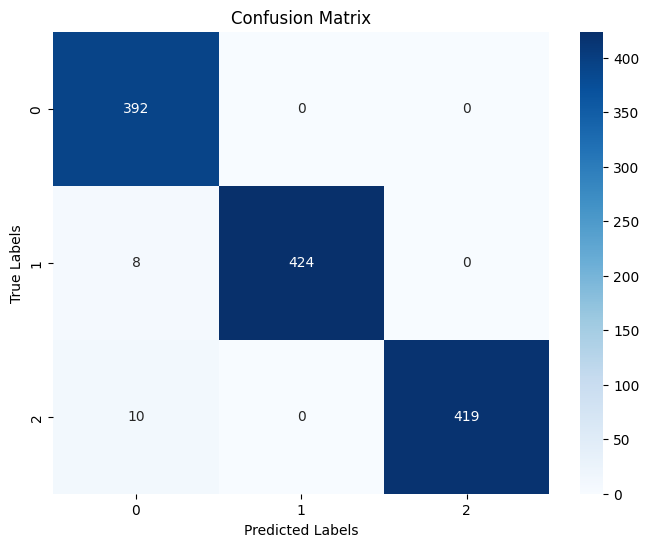

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       392
           1       1.00      0.98      0.99       432
           2       1.00      0.98      0.99       429

    accuracy                           0.99      1253
   macro avg       0.99      0.99      0.99      1253
weighted avg       0.99      0.99      0.99      1253



In [ ]:
y_pred = model.predict(test_x)
y_pred_classes = np.argmax(y_pred, axis=-1)

# Calculate confusion matrix
confusion_mtx = confusion_matrix(test_y, y_pred_classes)

# Display the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(test_y, y_pred_classes))


In [ ]:
%cd /content/drive/MyDrive/close_eyes

/content/drive/MyDrive/close_eyes


In [ ]:
X,Y = preprocess_data(itemNums, labelPath, OVERLAP_RATE, WINDOW_TIME)

NameError: ignored

In [ ]:
train_x, test_x,train_y, test_y  = train_test_split(X, Y, test_size=0.2, random_state=21,shuffle=True)
# select training and test data

In [ ]:
a,b,c = 0,0,0
for i in train_y:
  if i==0:
    a = a+1
  elif i==1:
    b=b+1
  elif i==2:
    c=c+1
print(a,b,c)

In [ ]:
#train_x, test_x = X[train_index], X[test_index]
#train_y, test_y = Y[train_index], Y[test_index]
# model training
model, scaler = train_model(train_x, train_y)
# standardize test data
for i in range(test_x.shape[0]):
    test_x[i] = scaler.transform(test_x[i])
# prepare shape of data
train_x = np.expand_dims(train_x, axis=-1)
test_x = np.expand_dims(test_x, axis=-1)

# Evaluate the model
y_pred = model.predict(test_x)
y_pred_classes = np.argmax(y_pred, axis=-1)

# Calculate confusion matrix
confusion_mtx = confusion_matrix(test_y, y_pred_classes)

# Display the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(test_y, y_pred_classes))